In [1]:
import numpy as np
import mat73
data_path1 = "D:\Datasets\s3\preprocessed data\pre_move\pre_eeg_L1.mat"
data_path2 = "D:\Datasets\s3\preprocessed data\pre_move\pre_eeg_L2.mat"
data_path3 = "D:\Datasets\s3\preprocessed data\pre_move\pre_eeg_L3.mat"
data_path4 = "D:\Datasets\s3\preprocessed data\pre_move\pre_eeg_L4.mat"
data1 = mat73.loadmat(data_path1)
eeg1 = data1['segs_1s']
pre_eeg1 = np.squeeze(np.stack([x for x in eeg1], axis=0).astype(np.float32), axis=1)
task_labels1 = data1['label_code']

data2 = mat73.loadmat(data_path2)
eeg2 = data2['segs_1s']
pre_eeg2 = np.squeeze(np.stack([x for x in eeg2], axis=0).astype(np.float32), axis=1)
task_labels2 = data2['label_code']

data3 = mat73.loadmat(data_path3)
eeg3 = data3['segs_1s']
pre_eeg3 = np.squeeze(np.stack([x for x in eeg3], axis=0).astype(np.float32), axis=1)
task_labels3 = data3['label_code']

data4 = mat73.loadmat(data_path4)
eeg4 = data4['segs_1s']
pre_eeg4 = np.squeeze(np.stack([x for x in eeg4], axis=0).astype(np.float32), axis=1)
task_labels4 = data4['label_code']

pre_eeg = np.concatenate((pre_eeg1, pre_eeg2,pre_eeg3,pre_eeg4), axis=0)
print(pre_eeg.shape)
task_labels = np.concatenate((task_labels1, task_labels2,task_labels3,task_labels4), axis=0)
print(task_labels.shape)

ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)


(240, 26, 200)
(240,)


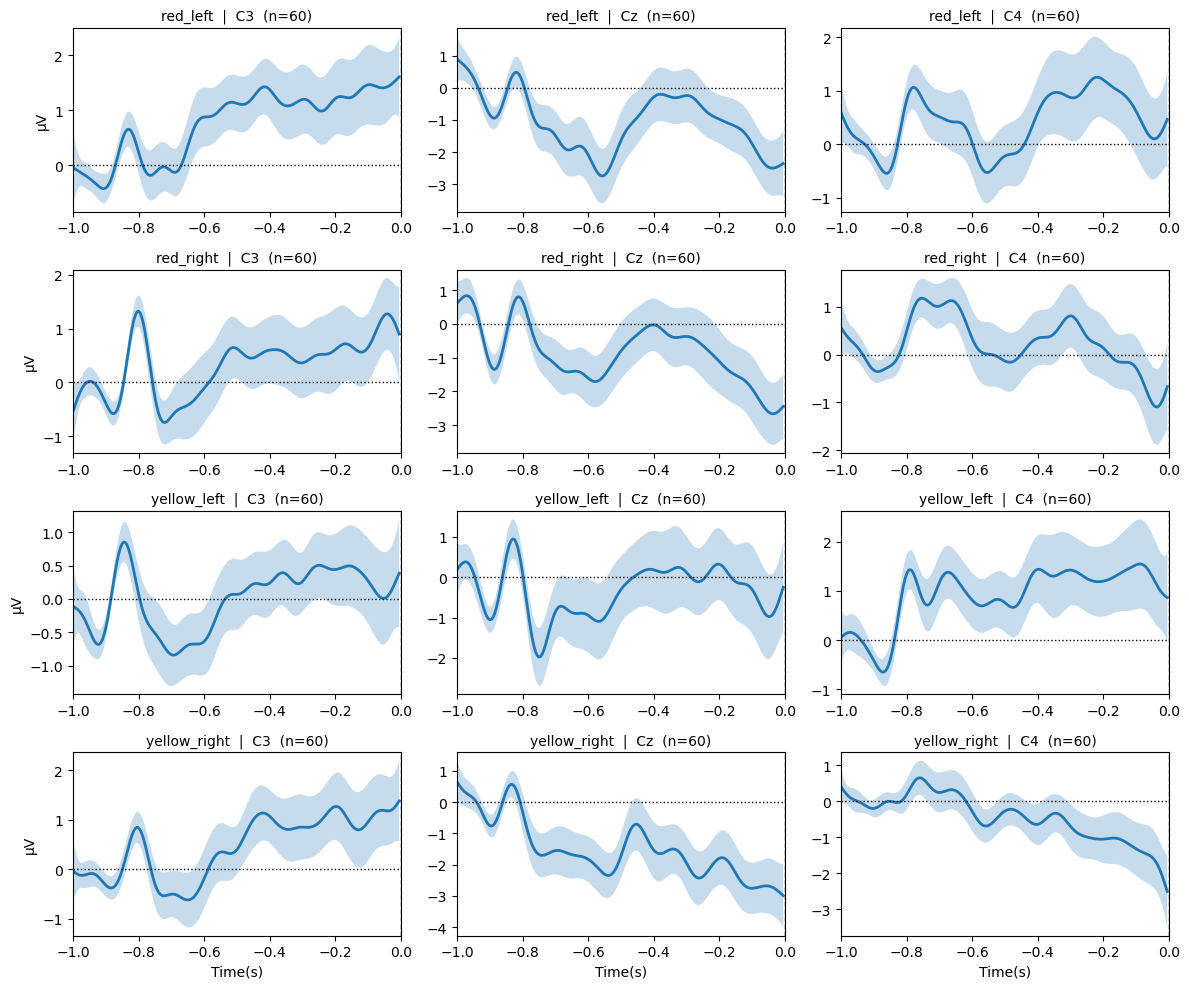

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ======= channel index=======
c3_idx = 11   # Example：C3 is in the 12th column  -> index11
cz_idx = 12   # Example：Cz is in the 13th column  -> index12
c4_idx = 13   # Example：C4 is in the 14th column  -> index13
# ============================================

# Low-pass filtering to 10Hz makes the RP smoother
def lp_filter(x, fs=200, cutoff=10.0):
    b, a = butter(4, cutoff/(fs/2), btype='low')
    return filtfilt(b, a, x, axis=-1)

def rp_mean_sem(pre_eeg, fs, ch_idx, baseline=(-1.0,-0.8), lp_hz=10.0):
    """
    pre_eeg: (n_trials, n_channels, 200)  [-1,0]s @ fs=200
    return the mean and SEM (after baseline correction) of this channel
    """
    x = pre_eeg[:, ch_idx, :]                         # (n_trials, T)
    if lp_hz is not None:
        x = lp_filter(x, fs=fs, cutoff=lp_hz)
    t = np.linspace(-1.0, 0.0, x.shape[-1], endpoint=False)
    bmask = (t >= baseline[0]) & (t <= baseline[1])
    x = x - x[:, bmask].mean(axis=1, keepdims=True)   # baseline correction
    mean = x.mean(axis=0)
    sem  = x.std(axis=0, ddof=1) / np.sqrt(x.shape[0])
    return t, mean, sem

# ======= Total data =======
# pre_eeg: (240, 26, 200)
# task_labels: (240,) in {0,1,2,3}

fs = 200
class_names = {
    0: 'red_left',
    1: 'red_right',
    2: 'yellow_left',
    3: 'yellow_right'
}
ch_order = [('C3', c3_idx), ('Cz', cz_idx), ('C4', c4_idx)]

# ======= Plot: 4 rows (categories) × 3 columns (channels) =======
plt.figure(figsize=(12, 10))
plot_idx = 1
for cls in [0,1,2,3]:
    sel = (task_labels == cls)
    if not np.any(sel):
        for _ in range(3):
            ax = plt.subplot(4,3,plot_idx); ax.axis('off'); plot_idx += 1
        continue
    for ch_name, ch_idx in ch_order:
        ax = plt.subplot(4,3,plot_idx)
        t, mean, sem = rp_mean_sem(pre_eeg[sel], fs=fs, ch_idx=ch_idx,
                                   baseline=(-1.0,-0.8), lp_hz=10.0)
        ax.plot(t, mean, lw=2)
        ax.fill_between(t, mean-1.96*sem, mean+1.96*sem, alpha=0.25)
        ax.axvline(0, ls='--', lw=1, c='k')
        ax.axhline(0, ls=':', lw=1, c='k')
        ax.set_xlim(-1.0, 0.0)
        if (plot_idx-1) % 3 == 0:
            ax.set_ylabel('µV')
        if plot_idx > 9:
            ax.set_xlabel('Time(s)')
        title = f"{class_names.get(cls, str(cls))}  |  {ch_name}  (n={sel.sum()})"
        ax.set_title(title, fontsize=10)
        plot_idx += 1

plt.tight_layout()
plt.savefig('./s3_left_rp.png', dpi=300)
plt.show()
